In [1]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter, ParameterList
import math
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
# %matplotlib inline  
# plt.ioff()
# plt.ion()

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [2]:
def PrepareDataset(speed_matrix, BATCH_SIZE = 40, seq_len = 10, pred_len = 1, train_propotion = 0.7, valid_propotion = 0.2):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert speed/volume/occupancy matrix to training and testing dataset. 
    The vertical axis of speed_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = speed_matrix.shape[0]
    
    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed
    
    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
    # shuffle and split the dataset to training and testing datasets
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.shuffle(index)
    
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
    valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
    test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    return train_dataloader, valid_dataloader, test_dataloader, max_speed

In [3]:
train_matrix =  pd.read_pickle('Training_speed_matrix_Didi_Xian_2016_Oct_01_30')
test_matrix =  pd.read_pickle('Testing_speed_matrix_Didi_Xian_2016_Dec_01')

In [4]:
speed_matrix = train_matrix

In [5]:
time_len = speed_matrix.shape[0]

In [6]:
max_speed = speed_matrix.max().max()
speed_matrix =  speed_matrix / max_speed

In [7]:
seq_len = 12

pred_len = 1

speed_sequences, speed_labels = [], []
for i in range(time_len - seq_len - pred_len):
    if pd.to_datetime(speed_matrix.iloc[i:i+seq_len].index.values[0]).hour <= 19:
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len][speed_matrix.columns.difference([20045, 46, 20866, 10867])].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len][[20045, 46, 20866, 10867]].values)
speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)

In [8]:
BATCH_SIZE = 40
seq_len = 12
pred_len = 1
train_propotion = 0.9
valid_propotion = 0.1

In [9]:
# shuffle and split the dataset to training and testing datasets
sample_size = speed_sequences.shape[0]
index = np.arange(sample_size, dtype = int)
np.random.shuffle(index)

train_index = int(np.floor(sample_size * train_propotion))
valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))

train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
valid_data, valid_label = speed_sequences[train_index:], speed_labels[train_index:]

train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)

train_dataset = utils.TensorDataset(train_data, train_label)
valid_dataset = utils.TensorDataset(valid_data, valid_label)

train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

In [10]:
test_matrix =  pd.read_pickle('Testing_speed_matrix_Didi_Xian_2016_Dec_01')
time_len = test_matrix.shape[0]
max_speed = test_matrix.max().max()
test_matrix =  test_matrix / max_speed

In [11]:
seq_len = 12

pred_len = 1

test_inputs, test_labels = [], []
for i in range(time_len - seq_len - pred_len):
    if pd.to_datetime(test_matrix.iloc[i:i+seq_len].index.values[0]).hour <= 19:
        test_inputs.append(test_matrix.iloc[i:i+seq_len][test_matrix.columns.difference([20045, 46, 20866, 10867])].values)
#         speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len][[20045, 46, 10047, 20866, 10867]].values)
test_inputs = np.asarray(test_inputs)
test_inputs = torch.Tensor(test_inputs)

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, time_size, predict_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()
        
        self.hidden_size = input_size
        self.fl = nn.Linear(input_size * 2, input_size)
        self.il = nn.Linear(input_size * 2, input_size)
        self.ol = nn.Linear(input_size * 2, input_size)
        self.Cl = nn.Linear(input_size * 2, input_size)
        
        self.attention = Variable(torch.ones((time_size, 1), dtype = dtype, device = device) / time_size, requires_grad = True)
#         self.attention = self.attention / time_size
        self.fully_connected = nn.Linear(input_size, predict_size)
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        
        combined = torch.cat((input, Hidden_State), 1)
        f = torch.sigmoid(self.fl(combined))
        i = torch.sigmoid(self.il(combined))
        o = torch.sigmoid(self.ol(combined))
        C = torch.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * torch.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        spatial_size = inputs.size(2)
        Hidden_State, Cell_State = self.initHidden(batch_size, spatial_size)
        
#         for i in range(time_step):
#             Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:], 1), Hidden_State, Cell_State)  
#         Hidden_State = F.sigmoid(self.fully_connected(Hidden_State))
        outputs = None
    
        for i in range(time_step):
            Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:], 1), Hidden_State, Cell_State)  
            if outputs is None:
                outputs = Hidden_State.unsqueeze(1)
            else:
                outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
        
#         print(outputs)
#         print(self.attention)
#         print(outputs.permute(0, 2, 1).shape)
        outputs = outputs.permute(0, 2, 1) 
#         outputs = torch.einsum('bij,jk->bik', outputs, self.attention)
#         print(outputs.shape)
#         print(self.attention.shape)
        outputs = torch.squeeze(torch.einsum('bij,jk->bik',(outputs, self.attention) ))
#         print(outputs.shape)
        outputs = F.sigmoid(self.fully_connected(outputs))
        return outputs
        
        
#         if self.output_last:
#             for i in range(time_step):
#                 Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
#             return Hidden_State
#         else:
#             outputs = None
#             for i in range(time_step):
#                 Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
#                 if outputs is None:
#                     outputs = Hidden_State.unsqueeze(1)
#                 else:
#                     outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
#             return outputs
    
    def initHidden(self, batch_size, spatial_size):
        Hidden_State = torch.zeros((batch_size, spatial_size), dtype = dtype, device = device)
        Cell_State = torch.zeros((batch_size, spatial_size), dtype = dtype, device = device)
        return Hidden_State, Cell_State
          

In [22]:
inputs_train, labels_train = next(iter(train_dataloader))
[batch_size, step_size, fea_size] = inputs_train.size()
pred_size = labels_train.size()[2]
inputs_val, labels_val = next(iter(valid_dataloader))

In [23]:
model = LSTM(fea_size, step_size, pred_size).cuda()

In [24]:
model = LSTM(fea_size, step_size, pred_size).cuda()
best_model = None
patience = 10

num_epochs = 100

min_delta = 0.000001

loss_MSE = torch.nn.MSELoss()
loss_L1 = torch.nn.L1Loss()

learning_rate = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

use_gpu = torch.cuda.is_available()

losses_train = []
losses_valid = []
losses_epochs_train = []
losses_epochs_valid = []

losses_all_train = []
losses_all_valid = []


cur_time = time.time()
pre_time = time.time()

# Variables for Early Stopping
is_best_model = 0
patient_epoch = 0

losses_epochs_valid_steps_l1 = [] 

for epoch in range(num_epochs):
    
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#     print('-' * 10)

    losses_epoch_train = []
    losses_epoch_valid = []

    train_start = time.time()

    for data in train_dataloader:
        inputs, labels = data

        if inputs.shape[0] != batch_size:
            continue

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: 
            inputs, labels = Variable(inputs), Variable(labels)

        model.zero_grad()

        outputs = model(inputs)

        if model.output_last:
            loss_train = loss_MSE(outputs, torch.squeeze(labels)) 
        else:
            loss_train = loss_MSE(outputs[:,-1,:], torch.squeeze(labels))

        losses_epoch_train.append(loss_train.item())

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

    train_end = time.time()
    
    # validation   
    valid_start = time.time()

    losses_l1_allsteps_val = []

    for data in valid_dataloader:

        inputs_val, labels_val = data

        if use_gpu:
            inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
        else: 
            inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)

        outputs_val= model(inputs_val)

        if model.output_last:
            loss_valid = loss_MSE(outputs_val, torch.squeeze(labels_val))

        losses_epoch_valid.append(loss_valid.item())

    valid_end = time.time()

    avg_losses_epoch_train = sum(losses_epoch_train) / float(len(losses_epoch_train))
    avg_losses_epoch_valid = sum(losses_epoch_valid) / float(len(losses_epoch_valid))
    losses_epochs_train.append(avg_losses_epoch_train)
    losses_epochs_valid.append(avg_losses_epoch_valid)
    losses_all_train.append(losses_epoch_train)
    losses_all_valid.append(losses_epoch_valid)
    
    # Early Stopping
    if epoch == 0:
        is_best_model = 1
        best_model = model
        min_loss_epoch_valid = 10000.0
        if avg_losses_epoch_valid < min_loss_epoch_valid:
            min_loss_epoch_valid = avg_losses_epoch_valid
    else:
        if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = avg_losses_epoch_valid 
            patient_epoch = 0
        else:
            is_best_model = 0
            patient_epoch += 1
            if patient_epoch >= patience:
                print('Early Stopped at Epoch:', epoch)
                break
                
    print('Epoch: {}, train_loss: {}, valid_loss: {}, train_time: {}, valid_time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([train_end - train_start] , decimals=2),\
                    np.around([valid_end - valid_start] , decimals=2),\
                    is_best_model) )


C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, train_loss: 0.01350749, valid_loss: 0.01060831, train_time: [5.08], valid_time: [0.18], best model: 1
Epoch: 1, train_loss: 0.01121075, valid_loss: 0.01026479, train_time: [5.08], valid_time: [0.18], best model: 1
Epoch: 2, train_loss: 0.01062404, valid_loss: 0.00998049, train_time: [5.05], valid_time: [0.2], best model: 1
Epoch: 3, train_loss: 0.01022502, valid_loss: 0.01058054, train_time: [5.05], valid_time: [0.18], best model: 0
Epoch: 4, train_loss: 0.00980679, valid_loss: 0.00928045, train_time: [5.08], valid_time: [0.24], best model: 1
Epoch: 5, train_loss: 0.00955645, valid_loss: 0.00904734, train_time: [5.07], valid_time: [0.18], best model: 1
Epoch: 6, train_loss: 0.00940964, valid_loss: 0.00948503, train_time: [5.05], valid_time: [0.18], best model: 0
Epoch: 7, train_loss: 0.00922767, valid_loss: 0.00923626, train_time: [5.05], valid_time: [0.18], best model: 0
Epoch: 8, train_loss: 0.00905823, valid_loss: 0.00950177, train_time: [5.07], valid_time: [0.18], best mo

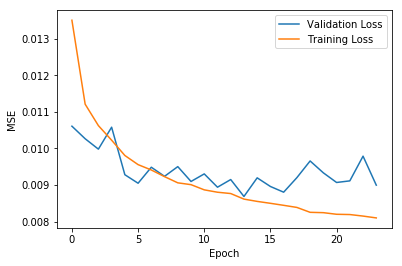

In [62]:
plt.plot(losses_epochs_valid, label = 'Validation Loss')
plt.plot(losses_epochs_train, label = 'Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('Train_valid_loss.png', dpi = 300)


In [26]:
def TrainModel(model, train_dataloader, valid_dataloader, learning_rate = 1e-5, num_epochs = 300, patience = 10, min_delta = 0.00001,):
    
    inputs, labels = next(iter(train_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()
    input_dim = fea_size
    hidden_dim = fea_size
    output_dim = fea_size
    
    model.cuda()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()

    learning_rate = 1e-5
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    
    use_gpu = torch.cuda.is_available()
    
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    
    losses_epochs_valid_steps_l1 = [] 
    
    for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)
        
        losses_epoch_train = []
        losses_epoch_valid = []

        train_start = time.time()
        
        for data in train_dataloader:
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else: 
                inputs, labels = Variable(inputs), Variable(labels)
                
            model.zero_grad()

            outputs = model(inputs)
            
            if model.output_last:
                loss_train = loss_MSE(outputs, torch.squeeze(labels)) 
            else:
                loss_train = loss_MSE(outputs[:,-1,:], torch.squeeze(labels))

            losses_epoch_train.append(loss_train.item())
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
        train_end = time.time()
        
        # validation   
        valid_start = time.time()
        
        losses_l1_allsteps_val = []
        
        for data in valid_dataloader:
            
            inputs_val, labels_val = data
            
            if use_gpu:
                inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
            else: 
                inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)

            outputs_val= model(inputs_val)
            
            if model.output_last:
                loss_valid = loss_MSE(outputs_val, torch.squeeze(labels_val))
            else:
                loss_valid = loss_MSE(outputs_val[:,-1,:], torch.squeeze(labels_val))
                
                full_labels_val = torch.cat((inputs_val[:,1:,:], labels_val), dim = 1)
                
                delta = torch.abs(full_labels_val - outputs_val)
                
                delta_batch_mean = torch.mean(delta, dim = 0)
                
                delta_batch_spatial_mean = torch.mean(delta_batch_mean, dim = 1)

                losses_l1_allsteps_val.append(delta_batch_spatial_mean.data.cpu().numpy())


    
            losses_epoch_valid.append(loss_valid.item())
        
        valid_end = time.time()
        
        avg_losses_epoch_train = sum(losses_epoch_train) / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid) / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
#         print(losses_l1_allsteps_val)
        
        if losses_l1_allsteps_val:
            losses_l1_allsteps_val = np.asarray(losses_l1_allsteps_val)
            losses_l1_allsteps_mean = np.mean(losses_l1_allsteps_val, 0)
            losses_epochs_valid_steps_l1.append(losses_l1_allsteps_mean)

            
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, train_time: {}, valid_time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([train_end - train_start] , decimals=2),\
                    np.around([valid_end - valid_start] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid, losses_epochs_valid_steps_l1]


In [42]:
np.expand_dims(best_model(torch.unsqueeze(Variable(inputs).cuda(),0)).data.cpu().numpy() * 60 , axis = 0)

C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[31.26335 , 31.265778, 34.61109 , 38.623135]], dtype=float32)

In [45]:
pred_set = None
for inputs in test_inputs:
#     print(inputs.shape)
    # Use best model to predict
    pred = np.expand_dims(best_model(torch.unsqueeze(Variable(inputs).cuda(),0)).data.cpu().numpy() * 60 , axis = 0)
    
    if pred_set is None:
        pred_set = pred
    else:
        pred_set = np.append(pred_set, pred, axis = 0)

C:\Users\Zhiyong\Anaconda3\envs\pytorch0.4\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [46]:
pred_set

array([[31.918495, 31.002892, 34.413906, 38.70549 ],
       [31.26335 , 31.265778, 34.61109 , 38.623135],
       [30.716364, 31.548504, 34.9078  , 38.67743 ],
       [30.456108, 31.80135 , 34.971203, 38.475132],
       [30.14337 , 31.327703, 34.871147, 38.227272],
       [29.78633 , 31.177923, 34.823338, 37.99158 ],
       [29.051537, 31.46622 , 34.705685, 37.209057],
       [28.405796, 31.71753 , 34.690884, 36.594917],
       [27.97106 , 31.707184, 34.480865, 36.03467 ],
       [27.903702, 31.622421, 34.058926, 35.744495],
       [28.043634, 31.510427, 33.655792, 35.791668],
       [28.16973 , 31.493584, 33.271885, 35.95357 ],
       [28.54711 , 30.678974, 32.780605, 36.203747],
       [29.307686, 30.27695 , 32.05249 , 36.444588],
       [29.046011, 31.037582, 31.945593, 35.725754],
       [28.744404, 30.873892, 31.234102, 34.80271 ],
       [28.308548, 30.64393 , 30.596888, 33.62727 ],
       [27.792713, 30.13929 , 29.933838, 31.973083],
       [26.981327, 29.684298, 29.494272, 30.33

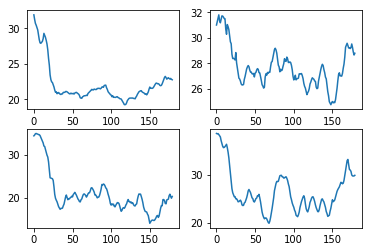

In [47]:
#20045, 46, 20866, 10867
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(pred_set[:,0], label = ['South, Link_id: 20045'])
ax[0, 1].plot(pred_set[:,1], label = ['South, Link_id: 46'])
ax[1, 0].plot(pred_set[:,2], label = ['North, Link_id: 20866'])
ax[1, 1].plot(pred_set[:,3], label = ['North, Link_id: 10867'])

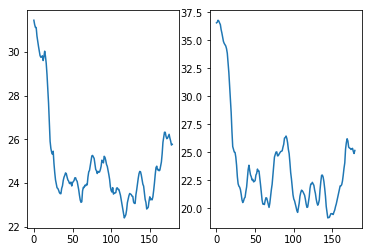

In [48]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot( (pred_set[:,0] + pred_set[:,1])/2 )
plt.subplot(1, 2, 2)
plt.plot( (pred_set[:,2] + pred_set[:,3])/2 )

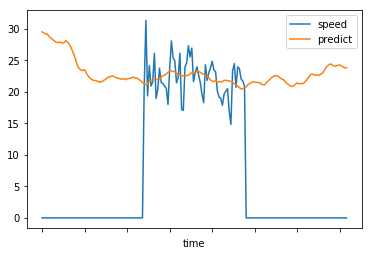

In [52]:
Predictions_south = pd.read_csv('prediction/Predictions_south.csv')
Predictions_south.speed = Predictions_south.speed.replace('x', 0)
Predictions_south.speed = Predictions_south.speed.astype(float)
time_06_00 = 5*12 + 3 
time_11_00 = 10*12 + 3 
time_16_00 = 15*12 + 3
time_21_00 = 20*12 + 3

predicted_south = (pred_set[:,0] + pred_set[:,1])/2

pred_avg = np.average(predicted_south[5 * 12: 10 * 12])
truth_avg = Predictions_south.iloc[time_11_00: time_16_00,:].speed.mean()
predicted_south = predicted_south - (pred_avg - truth_avg)

Predictions_south.iloc[time_06_00: time_21_00,:].plot(x = 'time', y = 'speed')
plt.plot(predicted_south, label = 'predict')
plt.legend()

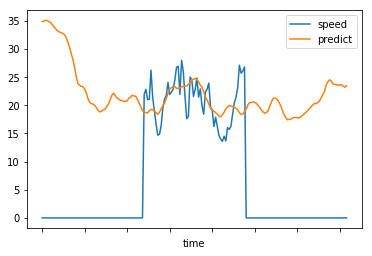

In [53]:
Predictions_north = pd.read_csv('prediction/Predictions_north.csv')
Predictions_north.speed = Predictions_north.speed.replace('x', 0)
Predictions_north.speed = Predictions_north.speed.astype(float)
time_06_00 = 5*12 + 8 
time_11_00 = 10*12 + 8 
time_16_00 = 15*12 + 8
time_21_00 = 20*12 + 8

predicted_north = (pred_set[:, 2] + pred_set[:, 3])/2

pred_avg = np.average(predicted_north[5 * 12: 10 * 12])
truth_avg = Predictions_north.iloc[time_11_00: time_16_00,:].speed.mean()
predicted_north = predicted_north - (pred_avg - truth_avg)

Predictions_north.iloc[time_06_00: time_21_00,:].plot(x = 'time', y = 'speed')
plt.plot(predicted_north, label = 'predict')
plt.legend()

In [54]:
pd.DataFrame(predicted_north).to_csv('predicted_north_v3.csv')

In [55]:
pd.DataFrame(predicted_south).to_csv('predicted_south_v3.csv')